In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
import matplotlib.pyplot as plt
# import psycopg2
import seaborn as sns
import pickle
import os
import sys

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from preprocessing import PreProcess
from overview import Overview
from plot import Plot
from loggers import Logger

In [4]:
loggers = Logger("userSatisfaction.log").get_app_logger()
loggers.info("Initialized user satisfaction logger")

In [5]:
df_org = pd.read_csv('../data/cleaned_data_outliers.csv')
df = df_org.copy()

In [6]:
# Import user experience data
user_exp = pd.read_csv('../data/user_exp.csv')

# Import user engagement data
user_eng = pd.read_csv('../data/user_eng.csv')

In [7]:
user_exp.head()

,MSISDN/Number,cluster,avg_rtt_total,avg_tp_total,total_avg_tcp_total
0,24.237822,0,8.114390,7.274480,23.201031
1,24.237822,0,3.401197,7.803027,23.201031
2,24.237822,0,5.416100,7.763021,23.201031
3,24.237822,1,6.942157,9.102310,16.921539
4,24.237822,1,8.114390,27.135851,49.213729


In [8]:
user_eng.head()

,MSISDN/Number,cluster,sessions,Dur. (ms),total_data
0,24.237822,0,1,11.667533,6.778433
1,24.237822,1,1,12.107522,5.055351
2,24.237822,2,1,11.812800,6.390184
3,24.237822,2,1,10.817335,6.045765
4,24.237822,0,2,19.656666,13.143197


In [9]:
with open("../models/user_eng.pkl", "rb") as f:
    kmeans1 = pickle.load(f)
    
with open("../models/user_exp.pkl", "rb") as f:
    kmeans2 = pickle.load(f)

In [10]:
user_eng_df = user_eng.set_index('MSISDN/Number')[
    ['sessions','Dur. (ms)', 'total_data']]
scaler = StandardScaler()
scaled_array = scaler.fit_transform(user_eng_df)
pd.DataFrame(scaled_array).head(5)

,0,1,2
0,-0.120240,-0.116165,-0.083693
1,-0.120240,-0.104045,-0.168510
2,-0.120240,-0.112164,-0.102804
3,-0.120240,-0.139586,-0.119758
4,0.177556,0.103914,0.229608


In [11]:
data_normalized = normalize(scaled_array)
pd.DataFrame(data_normalized).head(5)

,0,1,2
0,-0.643111,-0.621314,-0.447635
1,-0.518978,-0.449075,-0.727319
2,-0.620034,-0.578384,-0.530122
3,-0.547204,-0.635243,-0.545008
4,0.575933,0.337065,0.744774


In [12]:
distance = kmeans1.fit_transform(data_normalized)
distance_from_less_engagement = list(
    map(lambda x: x[3], distance))
user_eng['engagement_score'] = distance_from_less_engagement
user_eng.head(5)

,MSISDN/Number,cluster,sessions,Dur. (ms),total_data,engagement_score
0,24.237822,0,1,11.667533,6.778433,0.148540
1,24.237822,1,1,12.107522,5.055351,0.313709
2,24.237822,2,1,11.812800,6.390184,0.140515
3,24.237822,2,1,10.817335,6.045765,0.058808
4,24.237822,0,2,19.656666,13.143197,1.955241


In [18]:
user_expr = user_exp.copy()
# user_expr.drop([106855], axis=0, inplace=True)

In [19]:
exp_df = user_expr.set_index('MSISDN/Number')
distance = kmeans2.fit_transform(data_normalized)
distance_from_worest_experiance = list(
    map(lambda x: x[0], distance))
user_expr['experience_score'] = distance_from_worest_experiance
user_expr.head(5)

,MSISDN/Number,cluster,avg_rtt_total,avg_tp_total,total_avg_tcp_total,experience_score
0,24.237822,0,8.114390,7.274480,23.201031,0.067790
1,24.237822,0,3.401197,7.803027,23.201031,0.308925
2,24.237822,0,5.416100,7.763021,23.201031,0.073472
3,24.237822,1,6.942157,9.102310,16.921539,0.070612
4,24.237822,1,8.114390,27.135851,49.213729,1.957331


In [20]:
user_eng_id = user_eng['MSISDN/Number'].values
user_expr_id = user_expr['MSISDN/Number'].values
user_intersection = list(
    set(user_eng_id).intersection(user_expr_id))
user_intersection[:5]

[24.242603733828183,
 24.238122894935568,
 24.23986256243128,
 24.23819064464601,
 24.237825910629]

In [33]:
user_eng_df = user_eng[user_expr['MSISDN/Number'].isin(
    user_intersection)]

In [34]:


user_eng_df.shape



(106856, 6)

In [35]:
user_exper_df = user_expr[user_expr['MSISDN/Number'].isin(
    user_intersection)]

In [36]:
user_exper_df.shape

(106856, 6)

In [37]:
user_df = pd.merge(user_eng_df, user_exper_df, on='MSISDN/Number')
user_df['satisfaction_score'] = (user_df['engagement_score'] + user_df['experience_score'])/2
user_df.head(5)

,MSISDN/Number,cluster_x,sessions,Dur. (ms),total_data,engagement_score,cluster_y,avg_rtt_total,avg_tp_total,total_avg_tcp_total,experience_score,satisfaction_score
0,24.237822,0,1,11.667533,6.778433,0.148540,0,8.114390,7.274480,23.201031,0.067790,0.108165
1,24.237822,1,1,12.107522,5.055351,0.313709,0,3.401197,7.803027,23.201031,0.308925,0.311317
2,24.237822,2,1,11.812800,6.390184,0.140515,0,5.416100,7.763021,23.201031,0.073472,0.106994
3,24.237822,2,1,10.817335,6.045765,0.058808,1,6.942157,9.102310,16.921539,0.070612,0.064710
4,24.237822,0,2,19.656666,13.143197,1.955241,1,8.114390,27.135851,49.213729,1.957331,1.956286


In [42]:
satisfaction_df = user_df[['MSISDN/Number', 'engagement_score',
                        'experience_score', 'satisfaction_score']]
satisfaction_df = satisfaction_df.set_index('MSISDN/Number')

In [43]:
top_10_satisfaction = satisfaction_df.nlargest(10, 'satisfaction_score')
top_10_satisfaction.head(10)

,engagement_score,experience_score,satisfaction_score
MSISDN/Number,,,
24.239282,1.998502,1.995530,1.997016
24.243179,1.998508,1.995525,1.997016
24.238597,1.998553,1.995478,1.997016
24.242646,1.998531,1.995500,1.997015
24.239637,1.998554,1.995477,1.997015
24.242631,1.998487,1.995543,1.997015
24.242647,1.998565,1.995465,1.997015
24.240747,1.998469,1.995561,1.997015
24.239650,1.998566,1.995464,1.997015


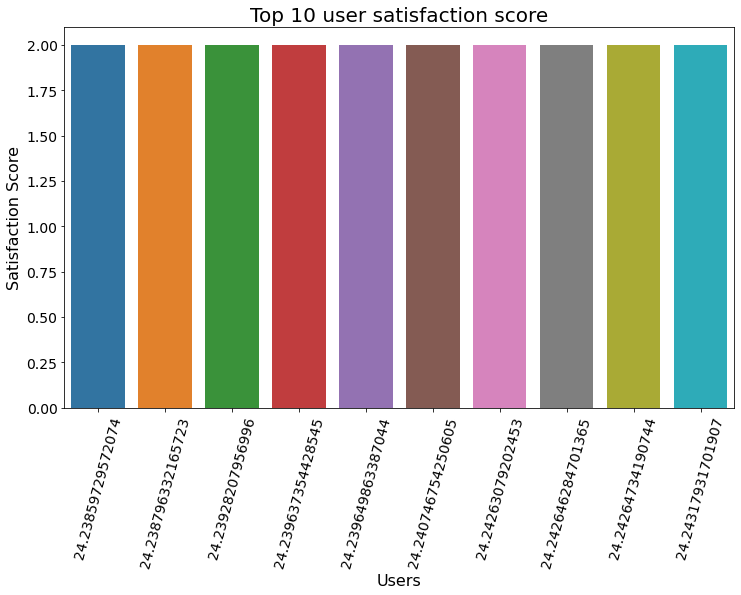

In [44]:
Plot().plot_bar(top_10_satisfaction, top_10_satisfaction.index, top_10_satisfaction['satisfaction_score'], "Top 10 user satisfaction score", "Users", "Satisfaction Score")


In [46]:
class Model:
    def __init__(self,X_train,X_test,y_train,y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test


    def model(self):
        self.trained_model = LinearRegression()
        self.trained_model.fit(self.X_train, self.y_train)
        

    def predict(self):
        self.model()
        return self.trained_model.predict(self.X_test)

    def score(self):
        return self.trained_model.score(self.X_test, self.y_test)

    def error_score(self):
        return np.mean((self.trained_model.predict(self.X_test) - self.y_test) ** 2)
    
    def save_model(self, path):
        pickle.dump(self.trained_model, open(path, 'wb'))

In [47]:
X = satisfaction_df[['engagement_score', 'experience_score']]
Y = satisfaction_df[['satisfaction_score']]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=42) 

In [48]:
model = Model(X_train, X_test, y_train, y_test)

In [49]:
model.predict()

array([[0.0480972 ],
       [0.12697709],
       [0.13276503],
       ...,
       [1.99387093],
       [1.99317045],
       [1.99107553]])

In [50]:
model.score()

1.0

In [51]:
model.error_score()


satisfaction_score    6.697547e-31
dtype: float64

In [52]:
model.save_model("../models/satisfaction_model.pkl")

In [53]:
user_df.head()


,MSISDN/Number,cluster_x,sessions,Dur. (ms),total_data,engagement_score,cluster_y,avg_rtt_total,avg_tp_total,total_avg_tcp_total,experience_score,satisfaction_score
0,24.237822,0,1,11.667533,6.778433,0.148540,0,8.114390,7.274480,23.201031,0.067790,0.108165
1,24.237822,1,1,12.107522,5.055351,0.313709,0,3.401197,7.803027,23.201031,0.308925,0.311317
2,24.237822,2,1,11.812800,6.390184,0.140515,0,5.416100,7.763021,23.201031,0.073472,0.106994
3,24.237822,2,1,10.817335,6.045765,0.058808,1,6.942157,9.102310,16.921539,0.070612,0.064710
4,24.237822,0,2,19.656666,13.143197,1.955241,1,8.114390,27.135851,49.213729,1.957331,1.956286


In [54]:
user_satisfaction_df = user_df[[
    'MSISDN/Number', 
    'engagement_score',
    'experience_score']]
user_satisfaction_df = user_satisfaction_df.set_index('MSISDN/Number')

In [55]:
user_satisfaction_df.head()

,engagement_score,experience_score
MSISDN/Number,,
24.237822,0.148540,0.067790
24.237822,0.313709,0.308925
24.237822,0.140515,0.073472
24.237822,0.058808,0.070612
24.237822,1.955241,1.957331


In [56]:
from sklearn.preprocessing import Normalizer

def normalizer(df, columns):
    norm = Normalizer()
    # normalize the exponential data with boxcox
    return pd.DataFrame(norm.fit_transform(df), columns=columns)

In [57]:
user_satisfaction_df

,engagement_score,experience_score
MSISDN/Number,,
24.237822,0.148540,0.067790
24.237822,0.313709,0.308925
24.237822,0.140515,0.073472
24.237822,0.058808,0.070612
24.237822,1.955241,1.957331
...,...,...
24.243431,0.160155,0.198561
24.243431,0.156277,0.110567
28.793241,0.447538,0.416803


In [58]:
normalized_df = normalizer(user_satisfaction_df, ['engagement_score', 'experience_score'] )


In [59]:
normalized_sat_df = normalized_df.copy()

In [60]:
kmeans = KMeans(init="random",n_clusters=2,n_init=10,max_iter=300,random_state=42)
label = kmeans.fit_predict(normalized_sat_df)
centroids = kmeans.cluster_centers_

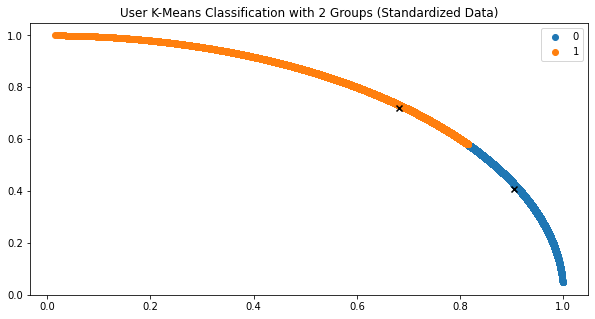

In [61]:
lables_unique = np.unique(label)
#plotting the results:
plt.figure(figsize=(10,5))
plt.title('User K-Means Classification with 2 Groups (Standardized Data)')
for i in lables_unique:
    plt.scatter(normalized_sat_df[label == i].iloc[:,0] , normalized_sat_df[label == i].iloc[:,1], marker='o', label = i)
plt.scatter(centroids[:,0] , centroids[:,1], marker='x', color = 'black')
plt.legend()
plt.show()


In [62]:
normalized_sat_df.head()

,engagement_score,experience_score
0,0.909739,0.415180
1,0.712520,0.701652
2,0.886170,0.463360
3,0.639959,0.768409
4,0.706729,0.707484


In [63]:
u_sat_eng = user_satisfaction_df.copy()

In [64]:
u_sat_eng.insert(0, 'cluster', kmeans.labels_)
u_sat_eng.head(5)

,cluster,engagement_score,experience_score
MSISDN/Number,,,
24.237822,0,0.148540,0.067790
24.237822,1,0.313709,0.308925
24.237822,0,0.140515,0.073472
24.237822,1,0.058808,0.070612
24.237822,1,1.955241,1.957331


In [65]:
u_sat_eng.to_csv('../data/user_satisfaction.csv')

In [66]:
agg_sat = u_sat_eng.groupby('cluster').agg(
    {'engagement_score': 'sum', 'experience_score': 'sum'})


In [67]:
agg_sat_df = pd.DataFrame()
agg_sat_df['cluster'] = agg_sat.index
agg_sat_df['engagement_score'] = agg_sat['engagement_score']
agg_sat_df['experience_score'] = agg_sat['experience_score']


In [68]:
agg_sat_df.head()

,cluster,engagement_score,experience_score
0,0,4035.531660,1933.084232
1,1,66072.711197,66336.314120


<AxesSubplot:xlabel='cluster', ylabel='engagement_score'>

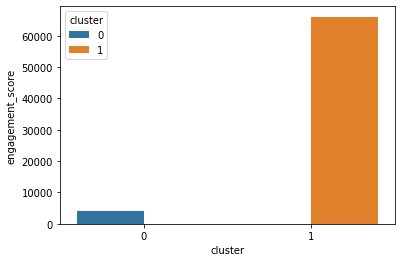

In [69]:
sns.barplot(x="cluster", y="engagement_score", hue="cluster", data=agg_sat_df)